In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


### Mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/NeuralODEs_ROM_Closure/neuralDDE_ROM_Closure

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/NeuralODEs_ROM_Closure/neuralDDE_ROM_Closure


### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn as adeq
import src.advec_diff_case.rom_advec_diff as rom

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

tf.keras.backend.set_floatx('float32')

## Define some useful classes

### Initial conditions

In [4]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1 + np.sqrt(1/self.app.t0) * np.exp(self.app.Re * self.x**2 / 4))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

### Analytical solution

In [5]:
class ad_eqn_analy:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u = self.x/ (t + 1) / (1 + np.sqrt((t + 1)/self.app.t0) * np.exp(self.app.Re * self.x**2 / (4 * t + 4)))
        return tf.convert_to_tensor([u], dtype=tf.float32)

## Main part starts here

### User-defined parameters, create objects, and solve the full order model

In [6]:
app = rom.rom_eqn_args(T = 2., nt = 200, L = 1., nx = 100, Re = 250, u_bc_0 = 0., u_bc_L =0., rom_dims = 2, rom_batch_size = 1, ad_eq_batch_size = 1)

x = tf.linspace(0., app.L, app.nx)
t = tf.linspace(0., app.T, app.nt) # Time array

u0 = initial_cond(x, app) # Initial conditions

op = adeq.operators(app)

u_fom = ddeinttf(adeq.ad_eqn(op), u0, t)

print('FOM done!')

FOM done!


### Solve th ROM model and plot

ROM done!


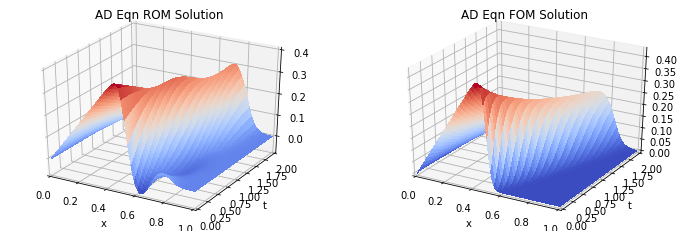

In [7]:
u_mean, ui = rom.create_mean_modes(ad_eqn_analy(x, app), app, t)()

ai_t0 = rom.initial_cond_rom(u0, ui, u_mean)

ai = ddeinttf(rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = app), ai_t0, t)

u_rom = tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [app.nt, app.rom_batch_size, 1]) \
            + tf.cast(tf.einsum('ab, cdb -> cda', tf.cast(ui, tf.float64), tf.cast(ai, tf.float64)), tf.float32)

print('ROM done!')

fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_u = fig.add_subplot(121, projection='3d')
ax_u_analy = fig.add_subplot(122, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('AD Eqn ROM Solution')
ax_u.set_xlabel('x')
ax_u.set_ylabel('t')
ax_u.plot_surface(X, T, tf.squeeze(u_rom, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

ax_u_analy.cla()
ax_u_analy.set_title('AD Eqn FOM Solution')
ax_u_analy.set_xlabel('x')
ax_u_analy.set_ylabel('t')
ax_u_analy.plot_surface(X, T, tf.squeeze(u_fom, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_analy.set_xlim(x[0], x[-1])
ax_u_analy.set_ylim(t[0], t[-1])

fig.show()